## Summary:

This is the second in a series of tutorials for building a character-level language model called "makemore," similar to a previous project named "micrograd." The main objective is to generate unique names based on a dataset of approximately 32,000 names sourced from a government website.

**Introduction to "makemore":** 
The project aims to create new names that sound unique by training on a dataset of names. The model will generate name-like strings that are not actual names, which can be useful for those looking for unique baby names.

**Character-Level Language Model:** 
"makemore" operates as a character-level language model, predicting the next character in a sequence based on the preceding characters. The tutorial will cover various models, including bi-gram models, multi-layer perceptrons, recurrent neural networks (RNNs), and transformers.

**Dataset Exploration:** 
The tutorial begins by loading the names.txt dataset into a Python program, exploring its characteristics, including the total number of names and the lengths of the shortest and longest names.

**Building a Bi-gram Model:** The instructor explains the concept of a bi-gram model, which predicts the next character based on the previous character. This model is simple but serves as a foundation for understanding more complex models.

**Counting Bigrams:** 
The tutorial details how to extract and count bigrams (pairs of consecutive characters) from the dataset using a dictionary to maintain counts for each bigram.

**Transition to Tensors:** The instructor discusses transitioning from a dictionary to a 2D array (tensor) for more efficient data manipulation, using PyTorch for its deep learning capabilities.

**Character Mapping:** 
A mapping from characters to integer indices is created to facilitate indexing into the 2D array, including special characters for start and end tokens.

**Implementation Steps:** The instructor outlines the coding steps to implement the bi-gram model, including handling character pairs and updating counts in the tensor.

The tutorial aims to guide students through the process of building a character-level language model step by step, laying the groundwork for more advanced neural network architectures in future sessions.

Kaparthy Implementation of MLP, following Bengio et al. 2003: https://youtu.be/TCH_1BHY58I?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ 

makemore (https://github.com/karpathy/makemore) takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an autoregressive character-level language model, with a wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble.

This is not meant to be too heavyweight library with a billion switches and knobs. It is one hackable file, and is mostly intended for educational purposes. PyTorch is the only requirement.

Current implementation follows a few key papers:

- Bigram (one character predicts the next one with a lookup table of counts)
MLP, following Bengio et al. 2003 https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
- CNN, following DeepMind WaveNet 2016 (in progress...) https://arxiv.org/abs/1609.03499
- RNN, following Mikolov et al. 2010 https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf
- LSTM, following Graves et al. 2014 https://arxiv.org/abs/1308.0850
GRU, following Kyunghyun Cho et al. 2014 https://arxiv.org/abs/1409.1259
- Transformer, following Vaswani et al. 2017 https://arxiv.org/abs/1706.03762
Usage
The included names.txt dataset, as an example, has the most common 32K names takes from ssa.gov https://www.ssa.gov/oact/babynames/ for the year 2018.

https://github.com/mdanok/Arabic-Names

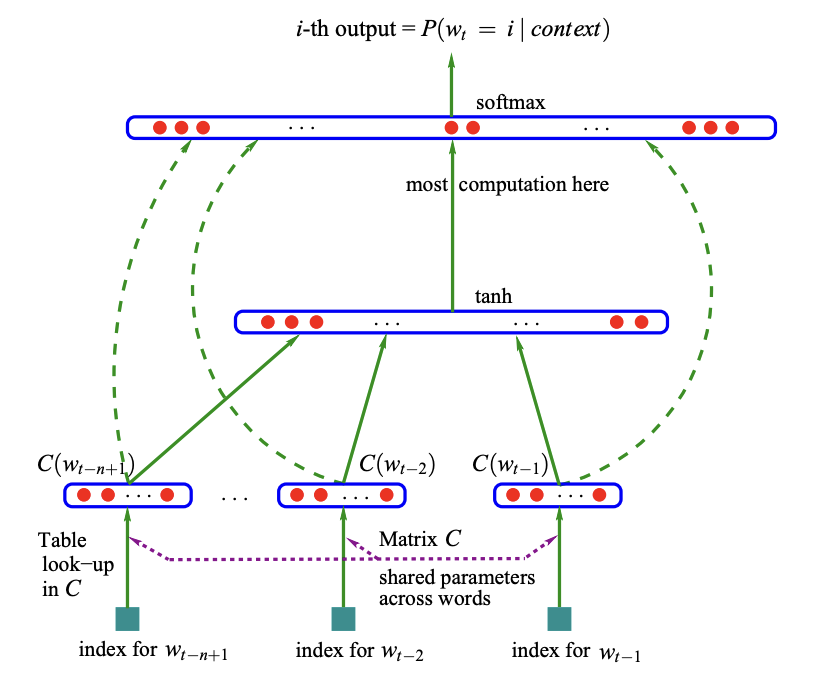

In [833]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [834]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims = True)
# loss = - prob[torch.arange(32), Y].log().mean()
# loss = F.cross_entropy(logits, Y)         # <=> to the above three lines, but much more efficient
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # <=> h = torch.tanh(emb.view(h.shape[0], 6) @ W1 + b)

In [835]:
# ------------------- #
# read the raw data
words = open('data/names.txt', 'r').read().splitlines()
# ------------------- #

In [836]:
# ------------------- #
# build the vocab of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
# ------------------- #

In [837]:
# ------------------- #
# get the parameters
# def get_parameters():

n_embd = 10              # the dimensionality of the character embedding vectors.
block_size = 5           # the number of of neurons in the hidden layer of the MLP.
n_hidden = 300           # number of neurons in hidden layer
vocab_size = len(stoi)   # number of characters
batch_size = 16          # number of elements in each batch
max_steps = 200000       # number of trainig steps; epochs
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
# number of parameters
# sum(p.nelement() for p in parameters)
C.shape
# ------------------- #

torch.Size([27, 10])

In [838]:
def build_dataset(words, block_size):
    # build the dataset
    X, Y, = [], []                       # do we take to predict the next one
    for w in words:                      # inputs and labels to the neural net.
        context = [0] * block_size
    
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

def split_dataset(value1, value2):
    n1 = int(value1*len(words))
    n2 = int(value2*len(words))
    return n1, n2

n1, n2 = split_dataset(0.8, 0.9)

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [839]:
def calculate_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

loss_tr =	 2.246553897857666 
loss_dev =	 2.282679796218872 
loss_te =	 2.2759556770324707


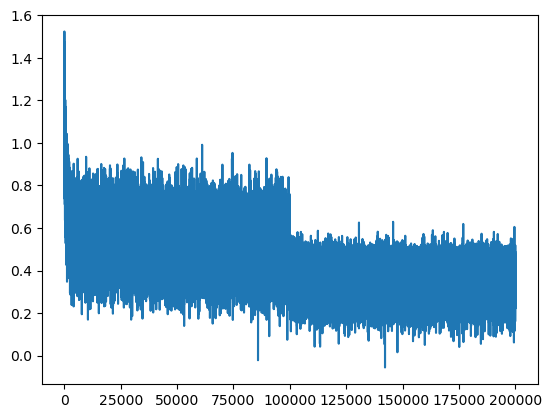

In [840]:
lri = []
lossi = []
stepi = []

def train_model(X, Y):
    lre = torch.linspace(-3, 0, 1000)
    lrs = 10**lre
        
    for step in range(max_steps):
        # minibatch of 32 elements at at time
        ix = torch.randint(0, X.shape[0], (batch_size,))
        # forward pass
        X.shape
        Y.shape
        loss = calculate_loss(X[ix], Y[ix])
        
        # print(loss.item())
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update
        # lr = lrs[step]
        lr = 0.1 if step < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad
    
        # track stats
        # lri.append(lre[step])
        lossi.append(loss.log10().item())
        stepi.append(step)
    plt.plot(stepi, lossi)

    return Xtr, Ytr

Xtr, Ytr = train_model(Xtr, Ytr)

loss_tr = calculate_loss(Xtr, Ytr)
loss_dev = calculate_loss(Xdev, Ydev)
loss_te = calculate_loss(Xte, Yte)

print("loss_tr =\t", loss_tr.item(), "\nloss_dev =\t", loss_dev.item(), "\nloss_te =\t", loss_te.item())

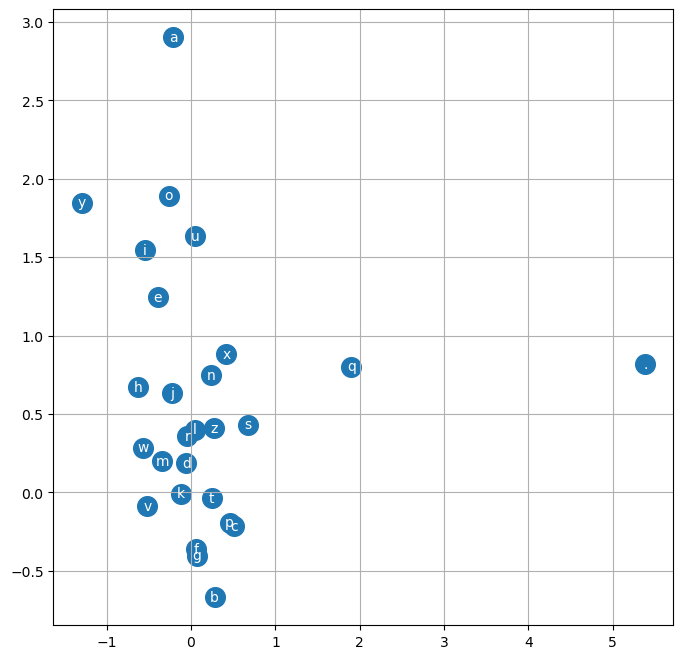

In [841]:
# ------------------- #
# visualize_embeddings
# ------------------- #
def visualize_embeddings():
    plt.figure(figsize=(8, 8))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
    plt.grid('minor')
visualize_embeddings()

In [842]:
# ------------------- #
# sample from the model
# ------------------- #
def sample_from_model():
    g = torch.Generator().manual_seed(2147483647 + 10 )
    
    for _ in range(20):
        out = []
        context = [0] * block_size # initialize with all dots
        while True:
            emb = C[torch.tensor([context])]                                                 
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)                  
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim = 1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(itos[ix])
            if ix == 0:
                break
        print(''.join(out))

sample_from_model()

careah.
ameli.
kihkin.
shree.
cahlan.
saejen.
nender.
syra.
kaqei.
nelmara.
chaily.
kalej.
phalm.
pocs.
qesnt.
srlingti.
adbi.
wazella.
jaryx.
kakae.
